In [1]:
from ddgs import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [2]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/45851/bird-blue-cristata-cyanocitta-45851.jpeg?cs=srgb&dl=pexels-pixabay-45851.jpg&fm=jpg'

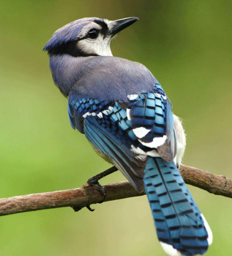

In [3]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

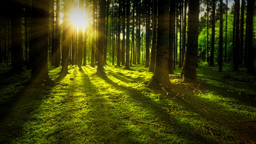

In [4]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [5]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/Users/rumpagiri/Projects/fastai-medical-ml/myenv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

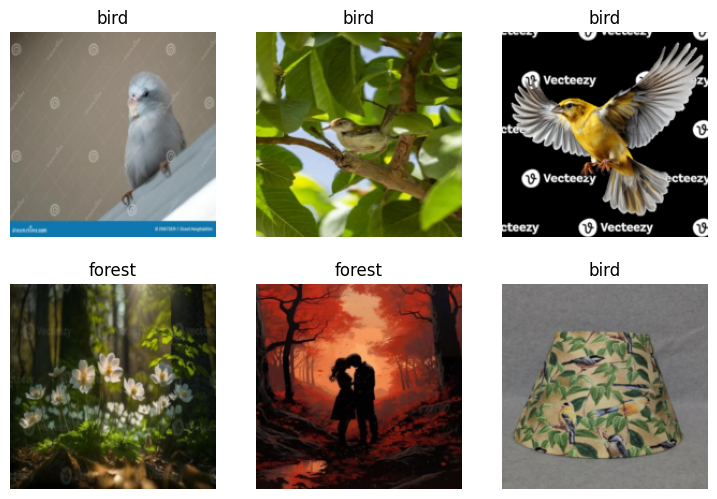

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.874135,0.782313,0.175439,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.233195,0.255081,0.096491,00:01
1,0.199306,0.209724,0.087719,00:01
2,0.146080,0.249232,0.070175,00:01
3,0.107441,0.307702,0.087719,00:01
4,0.082265,0.344845,0.087719,00:01
5,0.063858,0.365400,0.078947,00:01
6,0.053278,0.365401,0.087719,00:01
7,0.043738,0.364573,0.087719,00:01
8,0.036990,0.364334,0.087719,00:01
9,0.030898,0.363757,0.087719,00:01


In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [13]:

learn2 = vision_learner(dls, resnet34, metrics=error_rate)
learn2.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/rumpagiri/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████████████████████████████████████████████████| 83.3M/83.3M [00:02<00:00, 30.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.939745,0.745273,0.149123,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.390365,0.243016,0.105263,00:01
1,0.220776,0.254312,0.087719,00:01
2,0.148341,0.256871,0.087719,00:01


In [14]:
is_bird,_,probs = learn2.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998
